<a href="https://colab.research.google.com/github/alyelaswad/Assignment-3-CS2/blob/main/Labs/Lab4/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Text Generation with RNNs

In this assignment, you will explore text generation using deep learning models, specifically Recurrent Neural Networks (RNNs). Text generation is a fascinating task where the goal is to train a model that can predict the next word in a sequence, ultimately generating coherent and contextually accurate sentences or paragraphs.

You will work with a corpus of text data provided in the tutorial (from TensorFlow), which contains a large collection of Shakespeare’s works. Your objective is to implement a text generation model using RNNs and to evaluate its performance based on various metrics.

<img src="https://drek4537l1klr.cloudfront.net/teofili2/Figures/03fig09_alt.jpg" alt="Drawing"/>

**The models include:**
- Deep RNN (LSTM)
- Deep RNN (GRU)
- Bidirectional RNN


**Evaluation:**

Evaluate the performance of the text generation model using several metrics:
- Perplexity: A measure of how well the probability distribution predicted by the model aligns with the actual distribution of words in the text.
- Generated Text Quality: Subjectively evaluate the quality of the generated text by considering grammar, coherence, and creativity. This can be done by visually inspecting the generated sequences.
- BLUE Score: Character-level BLEU: BLEU can be applied at the character level by treating each character as an n-gram. This is particularly useful when the task involves generating character sequences (like poetry, code, or fine-grained character-based generation).
For example, the sequence “hello” could be evaluated by comparing 1-grams (e.g., “h”, “e”, “l”, “l”, “o”) or higher-order n-grams (e.g., “he”, “el”, “ll”, “lo”).

**Goals:**

- Compare the performance of GRU and LSTM. Is there a significant difference in the results?
- Compare the performance of the unidirectional and bidirectional RNN models.
Which model produces better results?
- Discuss the impact of bidirectional RNNs on text generation tasks.

# Import TensorFlow and other libraries

In [1]:
import tensorflow as tf
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu
import os
import time

# Dataset

The Shakespeare dataset used for text generation contains a collection of works by William Shakespeare, primarily in the form of plays and sonnets. The text is used to train language models, offering an ideal example for character-level modeling due to its rich, complex language. The dataset is often preprocessed by tokenizing it into individual characters, enabling models to learn the sequential relationships between characters for generating coherent and contextually appropriate text.

To access the dataset, you can use TensorFlow's get_file method as follow:

You can inspect the dataset on [Kaggle](https://www.kaggle.com/datasets/adarshpathak/shakespeare-text/data).

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Length of text: 1115394 characters


In [3]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



# Process the text

### Vectorize the text

Before training, you need to convert the strings to a numerical representation.

The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [4]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>


Now create the [`tf.keras.layers.StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) layer:

Since the goal of this assignment is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use tf.keras.layers.StringLookup(..., invert=True).

Note: Here instead of passing the original vocabulary generated with sorted(set(text)) use the get_vocabulary() method of the tf.keras.layers.StringLookup layer so that the [UNK] tokens is set the same way.

In [5]:
def get_string_lookup_layers(vocab):
    """
    Creates StringLookup layers for encoding characters to IDs and decoding IDs back to characters.

    Args:
        vocab (list): List of unique characters in the dataset.

    Returns:
        ids_from_chars (tf.keras.layers.StringLookup): Converts characters to IDs.
        chars_from_ids (tf.keras.layers.StringLookup): Converts IDs back to characters.
    """
    ids_from_chars = tf.keras.layers.StringLookup(vocabulary=vocab,mask_token=None)
    chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(),invert=True,mask_token=None)

    return ids_from_chars, chars_from_ids

In [6]:
def text_from_ids(ids, chars_from_ids):
    """
    Converts a sequence of character IDs into a human-readable string.

    Args:
        ids (tf.Tensor): Tensor of character IDs.
        chars_from_ids (tf.keras.layers.StringLookup): StringLookup layer to decode IDs.

    Returns:
        tf.Tensor: Decoded string.
    """
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain seq_length characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of seq_length+1. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.

For training you'll need a dataset of (input, label) pairs. Where input and label are sequences. At each time step the input is the current character and the label is the next character.

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [7]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

Convert Text to Numerical Sequences

In [8]:
# Initialize mapping layers
vocab = sorted(set(text))
ids_from_chars, chars_from_ids = get_string_lookup_layers(vocab)



# Convert text to character IDs
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

# Create a dataset from the character IDs
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

Create Sequences for Training

In [9]:
seq_length = 100  # Length of each training sequence

# Batch sequences (each sequence is seq_length + 1)
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)

# Map dataset to input-target format
dataset = sequences.map(split_input_target)

# Print sample input-output pairs
for input_example, target_example in dataset.take(1):
    print("Input :", tf.strings.reduce_join(chars_from_ids(input_example)).numpy().decode('utf-8'))
    print("Target:", tf.strings.reduce_join(chars_from_ids(target_example)).numpy().decode('utf-8'))


Input : First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Target: irst Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 


# Create RNN Models

Before training our text generation models, we need to set up key parameters and prepare the dataset. These parameters control the size of batches, buffer size for shuffling, embedding dimensions, and the number of units in the recurrent layer.

Customizing Parameters for Optimization

- Increase RNN_UNITS if the model is underfitting (not capturing enough detail).
- Decrease BATCH_SIZE if memory usage is too high (e.g., when using large RNN units).
- Adjust EMBEDDING_DIM to experiment with the quality of learned character representations.

Tip: Start with these values, then fine-tune based on model performance and available computational resources!

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
VOCAB_SIZE = len(vocab) + 1
DATASET_SIZE = sum(1 for _ in dataset)

shuffled_dataset = dataset.shuffle(BUFFER_SIZE)

train_dataset = shuffled_dataset.take(int(0.9 * DATASET_SIZE) )
val_dataset = shuffled_dataset.skip(int(0.1 * DATASET_SIZE) )

# Prepare dataset for training
training_dataset = (train_dataset
                 .batch(BATCH_SIZE, drop_remainder=True)
                 .prefetch(tf.data.experimental.AUTOTUNE))
# Prepare dataset for validation
validation_dataset = (val_dataset
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

# LSTM-Based Model

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) designed to capture long-range dependencies in sequential data. Unlike traditional RNNs, which struggle with vanishing gradients, LSTMs use gates (input, forget, and output gates) to regulate the flow of information, making them highly effective for text generation tasks.

This function defines an LSTM-based neural network for text generation.

**Function Overview:**
* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`.
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

In [18]:
def build_lstm_model(vocab_size, embedding_dim, rnn_units, batch_size):
  """TO DO"""
  """
    Builds an LSTM-based text generation model.

    Parameters:
    - vocab_size (int): Number of unique characters in the vocabulary.
    - embedding_dim (int): Dimension of the word/character embeddings.
    - rnn_units (int): Number of units in the LSTM layer.
    - batch_size (int): Number of sequences processed in parallel.

    Returns:
    - tf.keras.Model: Compiled LSTM model.
    """

  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim
      ),

      tf.keras.layers.LSTM(
          units=rnn_units,
          return_sequences=True,
          stateful=True,
          recurrent_initializer='glorot_uniform'
      ),

      tf.keras.layers.Dense(vocab_size)
      ])

  return model

**Customization & Optimization**

These experiments are required to improve model performance. You must conduct the following experiments and document your findings:

- Increase RNN_UNITS : This enhances the model’s ability to recognize deeper patterns but may increase training time.
- Experiment with EMBEDDING_DIM : Adjusting this can improve the quality of character representation.
- Stack multiple LSTM layers : This can help the model understand text more effectively.

**Submission Requirements**

- Perform at least three trials varying the parameters above.
- Keep the most performing plots and outputs in your Jupyter Notebook.


# GRU-Based Model

What is GRU?

Gated Recurrent Units (GRU) are a simplified version of LSTMs that combine the forget and input gates into a single update gate. This makes GRUs:

- Faster and more efficient than LSTMs
- Perform well on shorter sequences
- Require fewer computational resources

**Model Comparison (LSTM vs. GRU)**

To evaluate the differences between LSTM and GRU models, compare them using:

- Model Size & Number of Parameters : Use model.summary() to check the number of trainable parameters in each model.
- Training Speed & Efficiency : Measure training time per epoch for both models.

In [31]:
def build_gru_model(vocab_size, embedding_dim, rnn_units, batch_size):
    """TO DO"""
    """
    Builds a GRU-based text generation model.

    Parameters:
    - vocab_size (int): Number of unique characters in the vocabulary.
    - embedding_dim (int): Dimension of the word/character embeddings.
    - rnn_units (int): Number of units in the GRU layer.
    - batch_size (int): Number of sequences processed in parallel.

    Returns:
    - tf.keras.Model: Compiled GRU model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim
        ),

        tf.keras.layers.GRU(
            units=rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'
        ),

        tf.keras.layers.Dense(vocab_size)
    ])

    return model

# Bidirectional Model


<img src="https://www.researchgate.net/publication/342646275/figure/fig4/AS:962238546464790@1606426955772/Comparison-between-LSTM-and-Bi-LSTM-networks-recreated-after-33.png" alt="Drawing"/>


**What is Bidirectional RNN?**

A Bidirectional Recurrent Neural Network (BiRNN) is an extension of a standard RNN that processes input sequences in both forward and backward directions. This means that at each time step, the model considers both past (left-to-right) and future (right-to-left) context, leading to better performance in many sequence-related tasks, including text generation.

**Why Use Bidirectional RNNs?**

Bidirectional RNNs are used because they capture dependencies in the input data from both directions, which is crucial for understanding context. This makes them particularly useful in tasks like language processing, where the meaning of a word can depend on both the words that come before and after it.

For example, in the sentence "The cat sat on the mat," the word "mat" is influenced by both the preceding words ("The cat sat on the") and what could potentially follow (e.g., "and looked at the mouse").

Example

Let's consider a sentence: "He opened the door."

Simple RNN: It processes the sentence from left to right, word by word:

He → opened → the → door
Each word is processed based on the previous word.

Bidirectional RNN: It processes the sentence in both directions:

Forward pass: He → opened → the → door

Backward pass: door → the → opened → He

The output at each time step is a combination of the information from both the forward and backward passes, allowing the network to understand the context better. For instance, knowing that "door" follows "the" helps confirm that "opened" likely refers to a physical action, not a metaphorical one.

**Choosing the Base RNN for Bidirectional Processing:**

One key flexibility of Bidirectional RNNs is that you can choose any recurrent architecture (LSTM, GRU, Simple RNN) as the base model.

- Bidirectional LSTM: Best for handling long-range dependencies.
- Bidirectional GRU: More computationally efficient than LSTM.
- Bidirectional Simple RNN: Less commonly used due to vanishing gradient issues.

Note: To determine the best base model for the Bidirectional RNN, you must evaluate the results from your previous experiments with different architectures (eg. LSTM and GRU).

Review previous results from training LSTM and GRU models.
Compare their performance in terms of:

- Training time per epoch
- Model size (number of parameters)
- Loss and accuracy on validation data
- Quality of generated text

Based on your findings, select the best-performing model as the base architecture for the Bidirectional RNN.


In [32]:
def build_birnn_model(vocab_size, embedding_dim, rnn_units, batch_size, rnn_type="LSTM"):
    """TO DO"""
    """
    Builds a Bidirectional RNN-based text generation model.

    Parameters:
    - vocab_size (int): Number of unique characters in the vocabulary.
    - embedding_dim (int): Dimension of the word/character embeddings.
    - rnn_units (int): Number of units in the RNN layer.
    - batch_size (int): Number of sequences processed in parallel.
    - rnn_type (str): Type of RNN to use as the base (options: "LSTM", "GRU").

    Returns:
    - tf.keras.Model: Compiled Bidirectional RNN model.
    """
    # Select base RNN layer type
    if rnn_type.upper() == "LSTM":
        rnn_layer = tf.keras.layers.LSTM(
            units=rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'
        )
    elif rnn_type.upper() == "GRU":
        rnn_layer = tf.keras.layers.GRU(
            units=rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'
        )
    else:
        raise ValueError("Invalid rnn_type. Choose either 'LSTM' or 'GRU'.")

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim
        ),
        tf.keras.layers.Bidirectional(rnn_layer),
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

# Evaluating the Models

Model Selection

In [19]:
EMBEDDING_DIM = 256      # dimension of embedding vectors
RNN_UNITS = 1024         # number of LSTM units

In [36]:
# Choose model type
model_type = "BiLSTM"  # Change to "GRU" or "BiLSTM"

if model_type == "LSTM":
    model = build_lstm_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
elif model_type == "GRU":
    model = build_gru_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
elif model_type == "BiLSTM":
    model = build_birnn_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)

print(f"Using {model_type} model for training.")

Using BiLSTM model for training.


Compile & Train the Model

In [21]:
def compile_and_train(model, path, EPOCHS = 30):
  # Define loss function
  def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

  # Compile the model
  model.compile(optimizer='adam', loss=loss)

  # Ensure checkpoint directory exists
  checkpoint_dir = f'./{path}'
  os.makedirs(checkpoint_dir, exist_ok=True)

  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix + '.weights.h5',
    save_weights_only=True
  )

  # Train the model
  history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

  return history

# Generate Text Using the Model

In [22]:
class OneStepTextGenerator(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        """
        Initializes the OneStepTextGenerator.

        Parameters:
        - model: Trained text generation model (e.g., LSTM or GRU).
        - chars_from_ids: Function mapping character IDs to characters.
        - ids_from_chars: Function mapping characters to their respective IDs.
        - temperature (float): Controls randomness in text generation.
          -> Higher temperature (> 1.0): Produces more diverse and unpredictable text.
          -> Lower temperature (< 1.0): Makes the model more confident but results in repetitive text.
          -> Temperature = 1.0: Standard behavior without biasing randomness.
        """
        super().__init__()
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars
        self.temperature = temperature

    def generate_text(self, start_string, num_generate=1000):
        """
        Generates text one character at a time based on a starting string.

        Parameters:
        - start_string (str): Initial text prompt.
        - num_generate (int): Number of characters to generate.

        Returns:
        - str: Generated text.
        """
        # Convert start string to tensor representation
        input_eval = tf.expand_dims(self.ids_from_chars(tf.strings.unicode_split(start_string, 'UTF-8')), 0)
        text_generated = []

        # Initial hidden state (None allows automatic initialization)
        states = None

        for _ in range(num_generate):
            # Get model predictions and hidden state
            # predictions, states = self.model(input_eval, states=states, return_state=True)
            predictions = self.model(input_eval)

            # Adjust predictions using temperature
            predictions = predictions[:, -1, :] / self.temperature

            # Sample the next character ID from a probability distribution
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

            # Use the predicted ID as next input
            input_eval = tf.expand_dims([predicted_id], 0)

            # Convert ID back to character and append to output
            text_generated.append(self.chars_from_ids(predicted_id).numpy().decode('utf-8'))

        return start_string + ''.join(text_generated)


# Evaluate Model Performance

**1- Perplexity (PP)**

TODO: Measures uncertainty in predicting next character for each model and leave the results in the Notebook.

***Lower values = better model***

In [23]:
def perplexity(logits, labels):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return np.exp(np.mean(loss))

def evaluate_model_perplexity(model, dataset):
    total_loss = 0.0
    total_tokens = 0

    for input_batch, label_batch in dataset:
        logits = model(input_batch, training=False)
        loss = perplexity(logits, label_batch)
        total_loss += np.log(loss)
        total_tokens += tf.size(label_batch).numpy()

    avg_loss = total_loss / total_tokens
    return np.exp(avg_loss)

**2- Text Coherence & Fluency**

Subjective evaluation by examining generated text

**TODO: Generate at least 3 Samples (one from each model) and leave them in the Notebook.**

In [26]:
def generate_text_samples(one_step_generator, prompts, num_generate=300):
    """
    Generate text samples from given prompts.
    """
    generated_texts = []
    for p in prompts:
        text = one_step_generator.generate_text(p, num_generate=num_generate)
        print(f"\n🧩 Prompt: {p}\n{text}\n{'-'*60}")
        generated_texts.append(text)
    return generated_texts

**3- BLEU Score**

TODO: Measures similarity between generated and real text for each model and leave the results in the Notebook.

In [24]:
def compute_bleu(reference, generated):
    return sentence_bleu([list(reference)], list(generated))

def evaluate_model_bleu(model, dataset):
    bleu_scores = []

    for input_batch, label_batch in dataset:
        logits = model(input_batch, training=False)
        predictions = tf.argmax(logits, axis=-1)

        label_batch = label_batch.numpy()

        for pred_seq, true_seq in zip(predictions, label_batch):
            # Decode sequences to text
            pred_text = text_from_ids(pred_seq, chars_from_ids).numpy().decode('utf-8')
            true_text = text_from_ids(true_seq, chars_from_ids).numpy().decode('utf-8')

            # Compute BLEU score for each sample
            bleu = compute_bleu(true_text, pred_text)
            bleu_scores.append(bleu)

    return np.mean(bleu_scores)

## LSTM Evaluation

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 116ms/step - loss: 2.8599 - val_loss: 1.9654
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 1.8762 - val_loss: 1.6647
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 1.6200 - val_loss: 1.5097
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 1.4902 - val_loss: 1.4192
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 1.4129 - val_loss: 1.3624
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 1.3583 - val_loss: 1.3175
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 1.3192 - val_loss: 1.2823
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - loss: 1.2821 - val_loss: 1.2455
Epoch 9/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 1.2514 - val_loss: 1.2132
Epoch 10/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 1.2218 - val_loss: 1.1795
Epoch 11/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 1.1874 - val_loss: 1.1499
Epoch 12/30
155/155

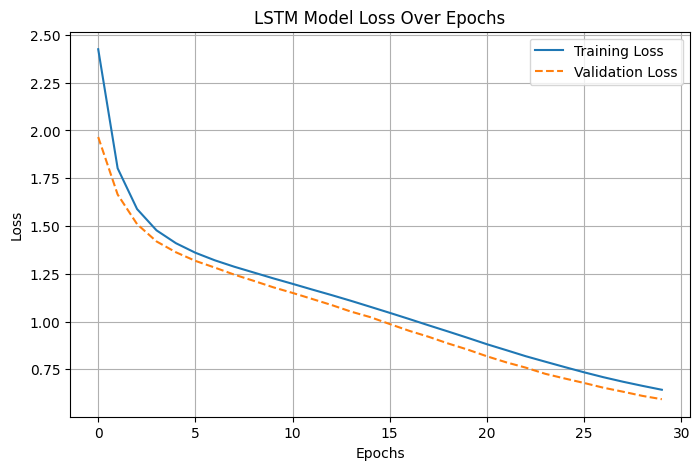

155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.5932

✅ Final Validation Loss: 0.5943

📝 Generated Text Sample:

Once upon a time
Would break about, and so well known to nothing.

EDWARD:
I will be his fult-monager; And in mine own
Where I have been too leifure, that
Which then depart with him: he is a wife,
We are to blame thee in my person for the name
Which next none burst,
Plead with him the hablest of the maids.

BAPTISTA:
What, is the dribe my brother's pardon!
Dost thou faint is done: and how the county Paris?
What schora
Uncold'd my fortunes and bayst thou bid Vicestire;
Tralition will return no more,
but discolve


In [25]:
import matplotlib.pyplot as plt
import os

def evaluate_and_visualize(model, model_type, chars_from_ids, ids_from_chars, training_dataset, validation_dataset, EPOCHS=30):
    """
    Compiles, trains, evaluates, and visualizes model performance.
    """

    # --- Step 1: Train the Model ---
    history = compile_and_train(model, path=f"{model_type}_training_checkpoints", EPOCHS=EPOCHS)

    # --- Step 2: Plot Training and Validation Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f"{model_type} Model Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 3: Evaluate on Validation Dataset ---
    val_loss = model.evaluate(validation_dataset)
    print(f"\nFinal Validation Loss: {val_loss:.4f}")

    # --- Step 4: Load the Latest Checkpoint ---
    checkpoint_dir = f"./{model_type}_training_checkpoints"
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print(f"\nLoading weights from: {latest_checkpoint}")
        model.load_weights(latest_checkpoint)

    # --- Step 5: Generate Text ---
    one_step_generator = OneStepTextGenerator(
        model=model,
        chars_from_ids=chars_from_ids,
        ids_from_chars=ids_from_chars,
        temperature=1.0  # Try 0.8 for smoother, 1.2 for more diverse text
    )

    start_prompt = "Once upon a time"
    generated_text = one_step_generator.generate_text(start_prompt, num_generate=500)

    print("\nGenerated Text Sample:\n")
    print(generated_text)

    return history, val_loss, generated_text


# Run the full evaluation pipeline
history, val_loss, sample_output = evaluate_and_visualize(
    model=model,
    model_type=model_type,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    EPOCHS=30
)


In [28]:
pp = evaluate_model_perplexity(model, validation_dataset)
print(f"\nModel Perplexity (PP): {pp:.4f}")

# Text Coherence & Fluency
one_step_generator = OneStepTextGenerator(model, chars_from_ids, ids_from_chars, temperature=1.0)
sample_prompts = ["Once upon a time", "In the future", "Deep learning is"]
generated_texts = generate_text_samples(one_step_generator, sample_prompts, num_generate=400)

# BLEU
bleu = evaluate_model_bleu(model, validation_dataset)
print(f"\nModel BLEU Score: {bleu:.4f}")


🧮 Model Perplexity (PP): 1.0001

🧩 Prompt: Once upon a time
Once upon a time;
Where's barnardy men;
For I have reason noto see 'em.'

MENENIUS:
I'll use me here. I'll have you thus forgot these shrift.

ESCALUS:
In the dorrow's name; I'll visit her,
And trouble Henry will be done.

CARIOLAN:
Out,
To counsel me to fail in our more rebel,
And duty blaze of it; for they would fly which you
good knows mean-loved
to him they have been a strict rebotf!

First Huntsman:
Before t
------------------------------------------------------------

🧩 Prompt: In the future
In the future of the deep,
And metic rebels strike at ours.
Your restraints I am not to see their heads. Stay, love, to lament
This profference loud upon a current.

GLOUCESTER:
And Warwickes none will plate again
The soldiers should appliut yourself in heart:
I hope it been calourage,
Keep death, now wed-wooing your old,
In congerps are done!

CATESBY:
My lord,
He will scrap me worse with death,
Who gentleman
----------------------

## GRU Evaluation

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 3.1138 - val_loss: 2.0562
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 1.9627 - val_loss: 1.7306
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 1.6838 - val_loss: 1.5583
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 1.5385 - val_loss: 1.4571
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 1.4509 - val_loss: 1.3901
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 1.3879 - val_loss: 1.3413
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - loss: 1.3462 - val_loss: 1.3037
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - loss: 1.3075 - val_loss: 1.2703
Epoch 9/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - loss: 1.2773 - val_loss: 1.2411
Epoch 10/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 1.2432 - val_loss: 1.2071
Epoch 11/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 1.2184 - val_loss: 1.1763
Epoch 12/30
155/155 ━━━━━━━━━━

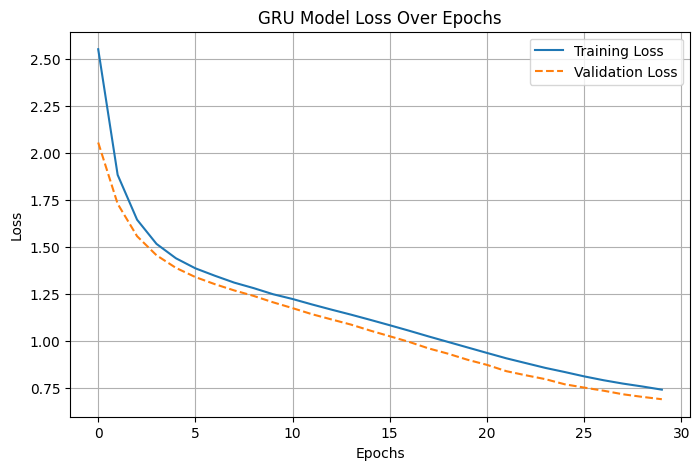

155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.6931

Final Validation Loss: 0.6926

Generated Text Sample:

Once upon a time cleave a punk,
And stooping to hell as to a-bowl of knowing Ely!
He deep angry and like Bianca mourn in manners.

WARWICK:
Why, thy greatness cook the banishment;
nip, my incresion, like a chiefe's bright stand;
Nor ce mudderer:
She had worntly; or woman after a strange as is't
Of the truth, our souls and runal sevending tears,
And wounded with the mind of Bolingbroke.

GREMIO:
Ay, and as I guess, Marcius it good to death.
3 KING HENRY VI:
This fiend that I keep thee a fool world against
honour


In [34]:
import matplotlib.pyplot as plt
import os

def evaluate_and_visualize(model, model_type, chars_from_ids, ids_from_chars, training_dataset, validation_dataset, EPOCHS=30):
    """
    Compiles, trains, evaluates, and visualizes model performance.
    """

    # --- Step 1: Train the Model ---
    history = compile_and_train(model, path=f"{model_type}_training_checkpoints", EPOCHS=EPOCHS)

    # --- Step 2: Plot Training and Validation Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f"{model_type} Model Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 3: Evaluate on Validation Dataset ---
    val_loss = model.evaluate(validation_dataset)
    print(f"\nFinal Validation Loss: {val_loss:.4f}")

    # --- Step 4: Load the Latest Checkpoint ---
    checkpoint_dir = f"./{model_type}_training_checkpoints"
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print(f"\nLoading weights from: {latest_checkpoint}")
        model.load_weights(latest_checkpoint)

    # --- Step 5: Generate Text ---
    one_step_generator = OneStepTextGenerator(
        model=model,
        chars_from_ids=chars_from_ids,
        ids_from_chars=ids_from_chars,
        temperature=1.0  # Try 0.8 for smoother, 1.2 for more diverse text
    )

    start_prompt = "Once upon a time"
    generated_text = one_step_generator.generate_text(start_prompt, num_generate=500)

    print("\nGenerated Text Sample:\n")
    print(generated_text)

    return history, val_loss, generated_text


# Run the full evaluation pipeline
history, val_loss, sample_output = evaluate_and_visualize(
    model=model,
    model_type=model_type,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    EPOCHS=30
)


In [35]:
pp = evaluate_model_perplexity(model, validation_dataset)
print(f"\nModel Perplexity (PP): {pp:.4f}")

# Text Coherence & Fluency
one_step_generator = OneStepTextGenerator(model, chars_from_ids, ids_from_chars, temperature=1.0)
sample_prompts = ["Once upon a time", "In the future", "Deep learning is"]
generated_texts = generate_text_samples(one_step_generator, sample_prompts, num_generate=400)

# BLEU
bleu = evaluate_model_bleu(model, validation_dataset)
print(f"\nModel BLEU Score: {bleu:.4f}")


Model Perplexity (PP): 1.0001

🧩 Prompt: Once upon a time
Once upon a time is well-spokened;
For rough me yet that dearly ride,
And yet so great a court in susgerfrim.

HORTENSIO:
The gain I seek worthy Margaret,
With the damnable time to view which way
To wail it. Antigonus,
Do me that you are out of, sir, a
good friend, give me thy toothath forsook. Farewell, my lord.

DUKE VINCENTIO:
You sorry that loss thence.

KATHARINA:
No sours' glad your expedience;
Put thy note
------------------------------------------------------------

🧩 Prompt: In the future
In the future; or a dukedom's wicked
Hot on the presence to us an each portellot that good to my soul.

ANGELIO:
They bear him coming in us,--

BUCKINGHAM:
Return'd my life, so quait, do not rum.

ANTIGONUS:
Lay be thy race, you have leave to any?

CATESBY:
Take her, sir, to yire, and dut the life detays't; but for himself.
If any man there, and, speaking open,
And let the enter time doth go find foo this died
------------------------

##Bidirectional LSTM Evaluation

Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - loss: 1.9892 - val_loss: 0.0799
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - loss: 0.0739 - val_loss: 0.0614
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - loss: 0.0600 - val_loss: 0.0546
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - loss: 0.0538 - val_loss: 0.0497
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - loss: 0.0491 - val_loss: 0.0474
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - loss: 0.0475 - val_loss: 0.0439
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - loss: 0.0443 - val_loss: 0.0417
Epoch 8/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - loss: 0.0412 - val_loss: 0.0388
Epoch 9/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - loss: 0.0395 - val_loss: 0.0367
Epoch 10/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - loss: 0.0374 - val_loss: 0.0352
Epoch 11/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - loss: 0.0352 - val_loss: 0.0324
Epoch 12/30
155/155

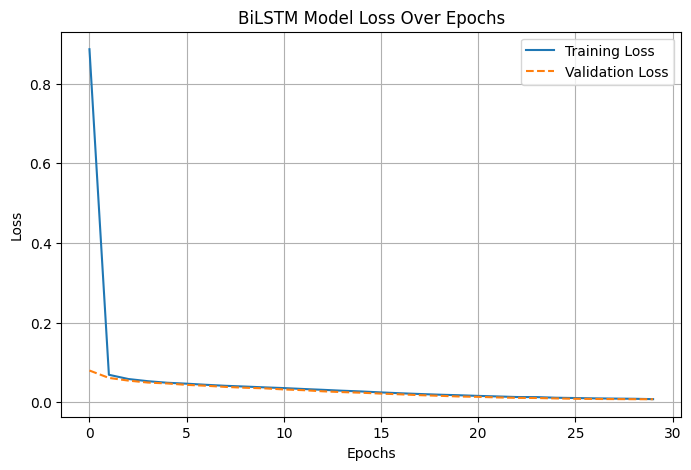

155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0076

Final Validation Loss: 0.0076

Generated Text Sample:

Once upon a timee, bebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebebe e I I I I I I I I I I I I I I I I crcacacacacacacacacacacscrcrcrcrcrcrcrcrcrcrcrcrckckckckcksksksksksksksksksksksksksksks
s
s
s
swswswnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwnwn'n's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's's'


In [37]:
import matplotlib.pyplot as plt
import os

def evaluate_and_visualize(model, model_type, chars_from_ids, ids_from_chars, training_dataset, validation_dataset, EPOCHS=30):
    """
    Compiles, trains, evaluates, and visualizes model performance.
    """

    # --- Step 1: Train the Model ---
    history = compile_and_train(model, path=f"{model_type}_training_checkpoints", EPOCHS=EPOCHS)

    # --- Step 2: Plot Training and Validation Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f"{model_type} Model Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 3: Evaluate on Validation Dataset ---
    val_loss = model.evaluate(validation_dataset)
    print(f"\nFinal Validation Loss: {val_loss:.4f}")

    # --- Step 4: Load the Latest Checkpoint ---
    checkpoint_dir = f"./{model_type}_training_checkpoints"
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print(f"\nLoading weights from: {latest_checkpoint}")
        model.load_weights(latest_checkpoint)

    # --- Step 5: Generate Text ---
    one_step_generator = OneStepTextGenerator(
        model=model,
        chars_from_ids=chars_from_ids,
        ids_from_chars=ids_from_chars,
        temperature=1.0  # Try 0.8 for smoother, 1.2 for more diverse text
    )

    start_prompt = "Once upon a time"
    generated_text = one_step_generator.generate_text(start_prompt, num_generate=500)

    print("\nGenerated Text Sample:\n")
    print(generated_text)

    return history, val_loss, generated_text


# Run the full evaluation pipeline
history, val_loss, sample_output = evaluate_and_visualize(
    model=model,
    model_type=model_type,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    training_dataset=training_dataset,
    validation_dataset=validation_dataset,
    EPOCHS=30
)


In [38]:
pp = evaluate_model_perplexity(model, validation_dataset)
print(f"\nModel Perplexity (PP): {pp:.4f}")

# Text Coherence & Fluency
one_step_generator = OneStepTextGenerator(model, chars_from_ids, ids_from_chars, temperature=1.0)
sample_prompts = ["Once upon a time", "In the future", "Deep learning is"]
generated_texts = generate_text_samples(one_step_generator, sample_prompts, num_generate=400)

# BLEU
bleu = evaluate_model_bleu(model, validation_dataset)
print(f"\nModel BLEU Score: {bleu:.4f}")


Model Perplexity (PP): 1.0000

🧩 Prompt: Once upon a time
Once upon a time? G G G G G G GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
------------------------------------------------------------

🧩 Prompt: In the future
In the future-I-I-I-I-I-I-I-I-I-I-I-I-I-IZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZIZI
------------------------